In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.stats import ortho_group
from scipy import fft
np.random.seed(0)

In [2]:
# utility function to generate random non singular covariance matrices with 
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        Q = ortho_group.rvs(d)
        decay = 0.4*(1 + np.random.random())
        eps = 1e-8
        U = np.ones(d,) * (np.random.rand() * 20) + 600
        for j in range(1,d):
            U[j] = max((U[j-1] * decay) + (np.random.rand() * 0.01), eps)
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return ans

In [3]:
# gmm recovery from a synthetic gmm
# make a representative gmm
def make_gmm(n_components, n_features, random_state=0):
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm.means_ = np.random.rand(n_components, n_features) * 4
    covariance_array = generate_covariance_matrices(n_components, n_features)
    # for i in range(n_components):
    #     rand_matrix = np.random.rand(n_features, n_features)
    #     covariance_array.append(np.dot(rand_matrix, rand_matrix.T))

    gmm.covariances_ = np.array(covariance_array)

    precision_array = [np.linalg.pinv(cov) for cov in covariance_array]
    gmm.precisions_ = np.array(precision_array)
    gmm.precisions_cholesky_ = np.array([np.linalg.cholesky(prec) for prec in precision_array])
    
    gmm.weights_ = np.random.rand(n_components)
    gmm.weights_ /= np.sum(gmm.weights_)
    return gmm

In [4]:
n_components = 5
n_features = 20

# my_test_gmm is the orcale gmm or source gmm
my_test_gmm = make_gmm(n_components, n_features)
my_test_gmm.sample(1)

(array([[  6.43206701,   8.04053848,  -8.57544467,   3.60821928,
          -9.82799177,   4.37449948,  -0.90418029, -15.49188414,
         -28.9327115 , -19.56942635,  13.19856135,  -5.62363442,
          -7.59978491,  18.30387825,   9.75685169,  -6.63127532,
          -2.32644404,   4.78647001,   4.01769018,  -6.18662671]]),
 array([1]))

In [5]:
# take compressive meaurements
# make 10 random measurement matrices
n_measurements = ((n_features * 5) // 10) # 50% of the features

measurement_matrices = []
for i in range(10):
    measurement_matrices.append(np.random.randn(n_measurements, n_features))
    # measurement_matrices.append(np.random.binomial(1, 0.5, size=(n_measurements, n_features)))

# generate samples from the gmm
n_samples = 10000
samples = my_test_gmm.sample(n_samples)

# take measurements
compressed_measurements = []
sample_measurement_matrix = []
for i in range(n_samples):
    matrix_index = np.random.randint(0, len(measurement_matrices))
    sample_measurement_matrix.append(matrix_index)
    compressed_measurements.append(np.dot(measurement_matrices[matrix_index], samples[0][i]))


noise_std_dev = 0.0005
noise_covariance_matrix = np.eye(n_measurements) * (noise_std_dev * noise_std_dev)
compressed_measurements = np.array(compressed_measurements)
comp_copy = compressed_measurements.copy()
compressed_measurements += np.random.normal(0, noise_std_dev, compressed_measurements.shape)
print(compressed_measurements.shape)
print(samples[0].shape)
print(measurement_matrices[0].shape)
print(len(sample_measurement_matrix))

diff = 0
for i in range(compressed_measurements.shape[0]):
    diff += np.linalg.norm(compressed_measurements[i] - comp_copy[i])

diff /= compressed_measurements.shape[0]
print(diff)

# estimated_gmm is fitted on the samples from the source
estimated_gmm = GaussianMixture(n_components=n_components,  n_init=5, verbose=1, max_iter=200, init_params='random')
estimated_gmm.fit(samples[0])

(10000, 10)
(10000, 20)
(10, 20)
10000
0.001546452540112334
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 10
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True


GaussianMixture(init_params='random', max_iter=200, n_components=5, n_init=5,
                verbose=1)

In [6]:
# for each of the 10 measurement matrices we have a separate gmm in the y-domain so let us make all of them p(y|z)

def form_y_gmms(x_gmm, measurement_matrices, noise_covariance_matrix):
    gmm_list = []
    noise_inverse = np.linalg.inv(noise_covariance_matrix)
    for i in range(len(measurement_matrices)):
        gmm_sample = GaussianMixture(n_components=n_components, random_state=0)
        gmm_sample.means_ = x_gmm.means_ @ measurement_matrices[i].T
        covariance_array = []

        for j in range(n_components):
            # C_ij = np.linalg.pinv(measurement_matrices[i].T @ noise_inverse @ measurement_matrices[i] + x_gmm.precisions_[j])
            # temp_matrix = noise_inverse @ measurement_matrices[i] @ C_ij @ measurement_matrices[i].T @ noise_inverse
            # covariance_array.append(np.linalg.pinv(noise_inverse - temp_matrix))
            covariance_array.append(noise_covariance_matrix  + measurement_matrices[i] @ x_gmm.covariances_[j] @ measurement_matrices[i].T)

        gmm_sample.covariances_ = np.array(covariance_array)
        gmm_sample.weights_ = x_gmm.weights_

        precision_array = [np.linalg.pinv(covariance_array[i]) for i in range(n_components)]
        gmm_sample.precisions_ = np.array(precision_array)
        gmm_sample.precisions_cholesky_ = np.array([np.linalg.cholesky(precision_array[i]) for i in range(n_components)])
        
        gmm_list.append(gmm_sample)
    return gmm_list

In [7]:
def get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, gmm_list):
    log_likelihood = 0
    for i in range(compressed_measurements.shape[0]):
        # print(gmm_list[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
        log_likelihood += gmm_list[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1))

    return log_likelihood/len(compressed_measurements)

In [8]:
def get_new_weights(compressed_measurements, y_gmms, sample_measurement_matrix, n_samples):
    # calculate p_ik
    new_weights = []
    for k in range(n_components):
        ssum = 0
        for i in range(n_samples):
            p_ik = y_gmms[sample_measurement_matrix[i]].weights_[k] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmms[sample_measurement_matrix[i]].means_[k], cov=y_gmms[sample_measurement_matrix[i]].covariances_[k]) / np.exp(y_gmms[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
            ssum += p_ik
        new_weights.append(ssum)
    new_weights = np.array(new_weights)
    new_weights /= np.sum(new_weights)
    return new_weights

In [9]:
def get_x_reconstruction(measurement_matrix, noise_covariance_matrix, x_covariance_matrix, x_mean, compressed_measurement):
    """
    gets the x reconstruction for a compressed sample for the z^th component in x (specified by x_covariance_matrix and x_mean)
    """
    # noise_inverse = np.linalg.pinv(noise_covariance_matrix)
    # C_z = np.linalg.pinv(measurement_matrix.T @ noise_inverse @ measurement_matrix + x_precision_matrix)
    C_z = np.linalg.pinv(noise_covariance_matrix + (measurement_matrix @ x_covariance_matrix @ measurement_matrix.T))
    x_reconstruction = x_mean + (x_covariance_matrix @ measurement_matrix.T @ C_z @ (compressed_measurement - measurement_matrix @ x_mean))
    return x_reconstruction    

In [10]:
def get_new_means(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, n_samples):
    new_means = []
    for k in range(n_components):
        ssum = 0
        psum = 0
        for i in range(n_samples):
            p_ik = y_gmms[sample_measurement_matrix[i]].weights_[k] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmms[sample_measurement_matrix[i]].means_[k], cov=y_gmms[sample_measurement_matrix[i]].covariances_[k]) / np.exp(y_gmms[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
            psum += p_ik
            n_ik = get_x_reconstruction(measurement_matrices[sample_measurement_matrix[i]], noise_covariance_matrix, estimated_gmm.covariances_[k], estimated_gmm.means_[k], compressed_measurements[i])
            ssum += p_ik * n_ik
        new_means.append(ssum/psum)
    new_means = np.array(new_means)
    return new_means

In [11]:
def get_new_covariances(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, new_means, n_samples):
    new_covariances = []
    for k in range(n_components):
        csum = 0
        psum = 0
        for i in range(n_samples):
            measurement_matrix = measurement_matrices[sample_measurement_matrix[i]]
            p_ik = y_gmms[sample_measurement_matrix[i]].weights_[k] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmms[sample_measurement_matrix[i]].means_[k], cov=y_gmms[sample_measurement_matrix[i]].covariances_[k]) / np.exp(y_gmms[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
            psum += p_ik
            n_ik = get_x_reconstruction(measurement_matrices[sample_measurement_matrix[i]], noise_covariance_matrix, estimated_gmm.covariances_[k], estimated_gmm.means_[k], compressed_measurements[i])
            C_ik = estimated_gmm.covariances_[k] - (estimated_gmm.covariances_[k] @ measurement_matrix.T @ np.linalg.pinv(noise_covariance_matrix + (measurement_matrix @ estimated_gmm.covariances_[k] @ measurement_matrix.T)) @ measurement_matrix @ estimated_gmm.covariances_[k])
            csum += p_ik * (C_ik + (n_ik - new_means[k]).reshape(-1, 1) @ (n_ik - new_means[k]).reshape(1, -1))
        new_covariances.append(csum/psum)
    new_covariances = np.array(new_covariances)
    return new_covariances

First check if the reconstruction is good using the suggested method (compare Max-Max estimate and MSE optimal estimate)

In [12]:
def weighted_l2(v, mat):
    if np.linalg.matrix_rank(mat) < mat.shape[0]:
        # handles the case where the matrix is not invertible
        m = v.T @ np.linalg.pinv(mat) @ v
    else:
        m = v.T @ np.linalg.inv(mat) @ v
    return m

In [13]:
def decode(model, A, y, noise_covariance_matrix):
    x_hat = np.empty(model.means_.shape)
    cost = []
    var_noise = noise_covariance_matrix

    for j in range(model.means_.shape[0]):
        var_j, mu_j = model.covariances_[j], model.means_[j]
        x_hat_j = var_j @ A.T @ np.linalg.pinv(A @ var_j @ A.T + var_noise) @ (y - A @ mu_j) + mu_j
        # print(np.linalg.det(var_j))
        # print(var_j)
        cost_j = weighted_l2(y - A @ x_hat_j, var_noise) + weighted_l2(x_hat_j - mu_j, var_j) + np.log(np.linalg.det(var_j))
        # print(np.linalg.det(var_j))
        x_hat[j] = x_hat_j
        cost.append(cost_j)

    j = np.argmin(cost)
    # print(j)
    return x_hat[j]

In [14]:
def error_metric(a, b, n_samples):
    err = 0
    for i in range(n_samples):
        err += np.sqrt(np.mean((a[i] - b[i])**2))
    return err/n_samples

In [15]:
# min MSE scheme
reconstructed_samples = []
y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)

for i in range(n_samples):
    y_gmm = y_gmms[sample_measurement_matrix[i]]
    reconstructed_sample = np.zeros(estimated_gmm.means_[0].shape)
    psum = 0
    for j in range(n_components):
        p_ik = y_gmm.weights_[j] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmm.means_[j], cov=y_gmm.covariances_[j]) / np.exp(y_gmm.score(compressed_measurements[i].reshape(1, -1)))
        psum += p_ik
        n_ik = get_x_reconstruction(measurement_matrices[sample_measurement_matrix[i]], noise_covariance_matrix, estimated_gmm.covariances_[j], estimated_gmm.means_[j], compressed_measurements[i])
        reconstructed_sample += p_ik * n_ik
    assert abs(psum - 1) < 1e-3
    reconstructed_samples.append(reconstructed_sample)

reconstructed_samples = np.array(reconstructed_samples)
print(f"Min MSE Mean RMSE: {error_metric(reconstructed_samples, samples[0], n_samples)}")

# max-max scheme
mm_recon = []
for i in range(n_samples):
    mm_recon.append(decode(estimated_gmm, measurement_matrices[sample_measurement_matrix[i]], compressed_measurements[i], noise_covariance_matrix))
mm_recon = np.array(mm_recon)
print(f"MM Mean RMSE: {error_metric(mm_recon, samples[0], n_samples)}")

# comparision with DCT scheme (retaining the lowest n_measurements coefficients)
dct_recon = []
for i in range(n_samples):
    tsfm = fft.dct(samples[0][i], norm='ortho')
    tsfm[n_measurements:] = 0
    dct_recon.append(fft.idct(tsfm, norm='ortho'))
dct_recon = np.array(dct_recon)
print(f"DCT Mean RMSE: {error_metric(dct_recon, samples[0], n_samples)}")

Min MSE Mean RMSE: 1.537663330255347
MM Mean RMSE: 1.579789994695467
DCT Mean RMSE: 5.798991345691386


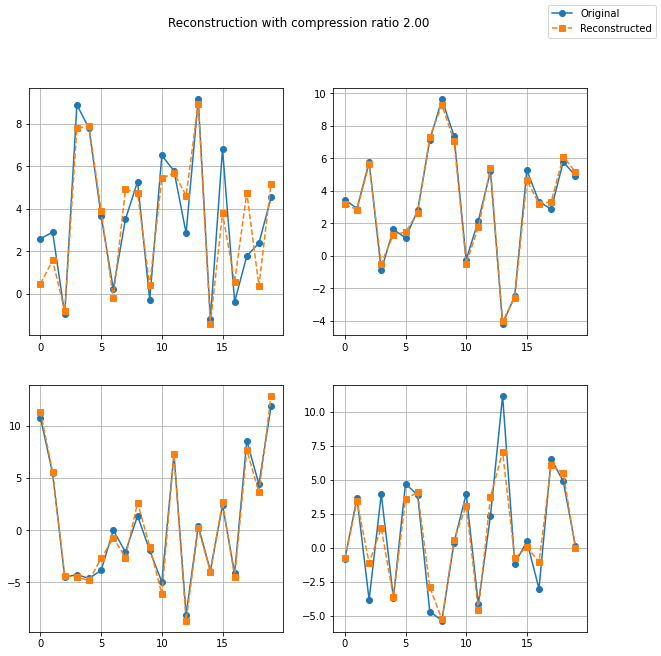

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
itc = 0
for i in (np.random.randint(0,n_samples, size=4)):
    ax[itc//2,itc%2].plot(samples[0][i], 'o-', label='Original')
    ax[itc//2,itc%2].plot(reconstructed_samples[i], 's--', label='Reconstructed')
    # ax[itc//2,itc%2].plot(dct_recon[i], 'x--', label='DCT')
    ax[itc//2,itc%2].grid()
    itc += 1    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
comp_ratio  = n_features/n_measurements
fig.suptitle(f"Reconstruction with compression ratio {comp_ratio:.2f}")
plt.savefig(f"./plots/CR{comp_ratio:.2f}.png")
plt.show()

In [17]:
def get_random_unit_vector(n):
    v = np.random.normal(size=n)
    return v/np.linalg.norm(v)

## With initial conditions
The following code is assuming only a slight deviation in the gmm, hence estimated gmm is initialised as being close to the original gmm

In [18]:
# utility function to shift gmm
def shift_gmm(original_gmm, fc):
    # shift means randomly by fc% of its norm and copy everything else as is
    for i in range(n_components):
        original_gmm.means_[i] = original_gmm.means_[i] + (fc * np.linalg.norm(original_gmm.means_[i]) * get_random_unit_vector(n_features))
        original_gmm.covariances_[i] = original_gmm.covariances_[i]
        original_gmm.precisions_[i] = original_gmm.precisions_[i]
        original_gmm.precisions_cholesky_[i] = original_gmm.precisions_cholesky_[i]
        original_gmm.weights_ = original_gmm.weights_

    return original_gmm

In [19]:
# initialise estimate of the original gmm
# assumption is that we know the number of components required to model the original gmm
# gmm_copy = make_gmm(n_components, n_features, random_state=7)
my_test_gmm = shift_gmm(my_test_gmm, 0.1)
# for i in range(n_components):
#     # shift mean randomly by 10% of its norm
#     print(f"Initial mean {i}: {estimated_gmm.means_[i]}")
#     print(f"Original mean {i}: {my_test_gmm.means_[i]}")

# generate samples from the gmm
n_samples = 1000
samples = my_test_gmm.sample(n_samples)

# take measurements
compressed_measurements = []
sample_measurement_matrix = []
for i in range(n_samples):
    matrix_index = np.random.randint(0, len(measurement_matrices))
    sample_measurement_matrix.append(matrix_index)
    compressed_measurements.append(np.dot(measurement_matrices[matrix_index], samples[0][i]))

compressed_measurements = np.array(compressed_measurements)
compressed_measurements += np.random.normal(0, noise_std_dev, compressed_measurements.shape)

# perform updates on the estimated gmm
# log likelihoods stores the log likelihoods of the estimated gmm computed on the samples drawn from the original gmm, our objective is to maximise this
tol = 0.05
log_likelihoods = []
y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)
log_likelihoods.append(get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, y_gmms))

print("Initial log likelihood: ", log_likelihoods[-1])
ideal_log_likelihood = get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, form_y_gmms(my_test_gmm, measurement_matrices, noise_covariance_matrix))
print("Ideal log likelihood: ", ideal_log_likelihood)

noise_inverse =  np.linalg.inv(noise_covariance_matrix)
iter_counter = 0

while True:

    new_weights = get_new_weights(compressed_measurements, y_gmms, sample_measurement_matrix,n_samples)
    new_means = get_new_means(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix,n_samples)
    new_covariances = get_new_covariances(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, new_means,n_samples)
    # estimated_gmm.weights_ = get_new_weights(compressed_measurements, y_gmms, sample_measurement_matrix)
    # estimated_gmm.means_ = get_new_means(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix)
    # estimated_gmm.covariances_ = get_new_covariances(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, estimated_gmm.means_)
    estimated_gmm.weights_ = new_weights
    estimated_gmm.means_ = new_means
    estimated_gmm.covariances_ = new_covariances
    
    precision_array = [np.linalg.pinv(cov) for cov in estimated_gmm.covariances_]
    estimated_gmm.precisions_ = np.array(precision_array)
    estimated_gmm.precisions_cholesky_ = np.array([np.linalg.cholesky(prec) for prec in estimated_gmm.precisions_])

    y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)
    log_likelihoods.append(get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, y_gmms))
    print(f"Iteration {iter_counter + 1} log-likelihood: {log_likelihoods[-1]}")
    iter_counter += 1
    if abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol or log_likelihoods[-1] > ideal_log_likelihood:
        if abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print("Converged")
            break
        # else:
        #     print("Ideal log-likelihood reached, stopping to avoid overfitting")


Initial log likelihood:  -41.9989472161186
Ideal log likelihood:  -41.66244929282188
Iteration 1 log-likelihood: -41.60235202372817
Iteration 2 log-likelihood: -41.51600293184901
Iteration 3 log-likelihood: -41.466151472281325
Converged


In [20]:
# get test sample set, take compressive measurements, reconstruct and check rmse
n_test = 500
test_sample_set = my_test_gmm.sample(n_samples=n_test)[0]
test_compressed_measurements = []
test_sample_matrix_indices = []
for i in range(n_test):
    matrix_index = np.random.randint(0, len(measurement_matrices))
    test_sample_matrix_indices.append(matrix_index)
    test_compressed_measurements.append(measurement_matrices[matrix_index] @ test_sample_set[i])

test_reconstructed_samples = []
test_reconstructed_samples_with_original_gmm = []
y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)
y_gmms_orig = form_y_gmms(my_test_gmm, measurement_matrices, noise_covariance_matrix)

for i in range(n_test):
    y_gmm = y_gmms[test_sample_matrix_indices[i]]
    y_gmm_orig = y_gmms_orig[test_sample_matrix_indices[i]]
    reconstructed_sample = np.zeros(estimated_gmm.means_[0].shape)
    reconstructed_sample_orig = np.zeros(my_test_gmm.means_[0].shape)
    psum = 0
    psum_orig = 0
    for j in range(n_components):
        p_ik = y_gmm.weights_[j] * multivariate_normal.pdf(test_compressed_measurements[i], mean=y_gmm.means_[j], cov=y_gmm.covariances_[j]) / np.exp(y_gmm.score(test_compressed_measurements[i].reshape(1, -1)))
        p_ik_orig = y_gmm_orig.weights_[j] * multivariate_normal.pdf(test_compressed_measurements[i], mean=y_gmm_orig.means_[j], cov=y_gmm_orig.covariances_[j]) / np.exp(y_gmm_orig.score(test_compressed_measurements[i].reshape(1, -1)))
        psum += p_ik
        psum_orig += p_ik_orig
        n_ik = get_x_reconstruction(measurement_matrices[test_sample_matrix_indices[i]], noise_covariance_matrix, estimated_gmm.covariances_[j], estimated_gmm.means_[j], test_compressed_measurements[i])
        n_ik_orig = get_x_reconstruction(measurement_matrices[test_sample_matrix_indices[i]], noise_covariance_matrix, my_test_gmm.covariances_[j], my_test_gmm.means_[j], test_compressed_measurements[i])
        reconstructed_sample += p_ik * n_ik
        reconstructed_sample_orig += p_ik_orig * n_ik_orig
    assert abs(psum - 1) < 1e-3
    assert abs(psum_orig - 1) < 1e-3
    test_reconstructed_samples.append(reconstructed_sample)
    test_reconstructed_samples_with_original_gmm.append(reconstructed_sample_orig)

test_reconstructed_samples = np.array(test_reconstructed_samples)
test_reconstructed_samples_with_original_gmm = np.array(test_reconstructed_samples_with_original_gmm)
print(f"Test Mean RMSE: {error_metric(test_sample_set, test_reconstructed_samples,n_test)}")
print(f"Test Mean RMSE with original GMM: {error_metric(test_sample_set, test_reconstructed_samples_with_original_gmm,n_test)}")

Test Mean RMSE: 1.7730979165573382
Test Mean RMSE with original GMM: 1.6412696500617188


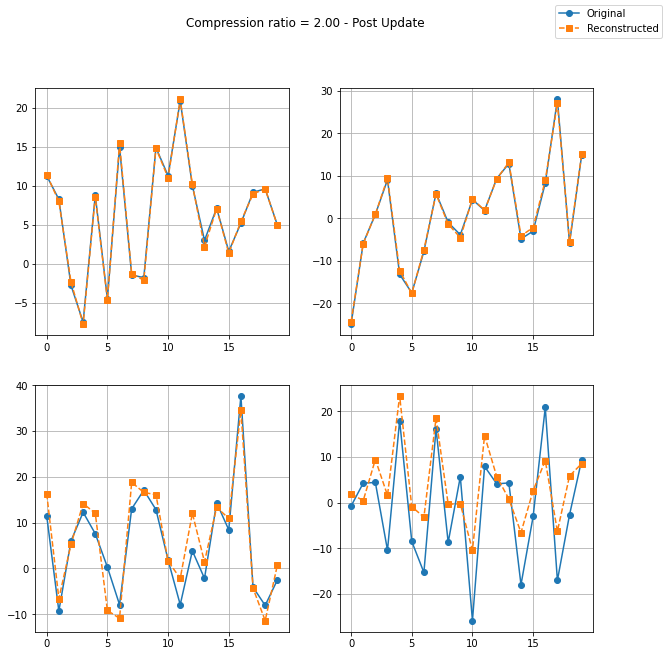

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
itc = 0
for i in (np.random.randint(0,n_test, size=4)):
    ax[itc//2,itc%2].plot(test_sample_set[i], 'o-', label='Original')
    ax[itc//2,itc%2].plot(test_reconstructed_samples[i], 's--', label='Reconstructed')
    ax[itc//2,itc%2].grid()
    itc += 1    
compression_ratio = n_features / n_measurements
fig.suptitle(f"Compression ratio = {compression_ratio:.2f} - Post Update")
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.savefig(f"./plots/CR_{compression_ratio:.2f}_post_update.png")
plt.show()